# 敏感与拮抗药物 IC50-ZScore 散点图

## 1. 数据预处理

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

In [2]:
df_cell_blind = pd.read_csv('drug_sensitivity_lung_CellBlind_test&prediction.csv',index_col=0)
print(df_cell_blind.shape)
df_cell_blind.head(1)

(12630, 5)


,drug,cell_line,IC50,OncotreeCode,prediction
0,5-Fluorouracil,OPM2,3.454205,PCM,3.180841


In [3]:
df_gdsc = pd.read_csv('df_gdsc_StrippedCellLineName.csv',index_col=0)[['Drug Name','Cell Line Name','Z score']]
# 将df_gdsc的Drug Name，Cell Line Name改为drug和cell_line
df_gdsc.columns = ['drug','cell_line','Z score']
# 将存在drug，cell_line重复的数据取平均
df_gdsc = df_gdsc.groupby(['drug','cell_line']).mean().reset_index()
print(df_gdsc.shape)
df_gdsc.head(1)

(236845, 3)


,drug,cell_line,Z score
0,123138,22RV1,-0.257761


In [4]:
df_drug_target = pd.read_csv('GDSC2_Drug_Pathway_Target.csv',index_col=0)[['Drug name','Drug target','Target Pathway']]
# 将Drug name改为drug
df_drug_target.columns = ['drug','Drug target','Target Pathway']
# 将存在drug重复的数据删除
df_drug_target = df_drug_target.drop_duplicates(subset='drug')
print(df_drug_target.shape)
df_drug_target.head(1)

(288, 3)


,drug,Drug target,Target Pathway
0,123138,NaN,Unclassified


In [5]:
# 将df_cell_blind和df_gdsc合并，按照drug和cell_line合并,df_cell_blind为主
df = pd.merge(df_cell_blind,df_gdsc,on=['drug','cell_line'],how='inner')
print(df.shape)
df.head(1)

(12630, 6)


,drug,cell_line,IC50,OncotreeCode,prediction,Z score
0,5-Fluorouracil,OPM2,3.454205,PCM,3.180841,-0.545439


In [6]:
# 将df和df_drug_target合并，按照drug合并,df为主
df = pd.merge(df,df_drug_target,on='drug',how='inner')
print(df.shape)
df.head(1)

(12630, 8)


,drug,cell_line,IC50,OncotreeCode,prediction,Z score,Drug target,Target Pathway
0,5-Fluorouracil,OPM2,3.454205,PCM,3.180841,-0.545439,Antimetabolite (DNA & RNA),Other


In [7]:
# 新增一个属性，Type，表示是否为敏感或者拮抗药物，Z score=>2为拮抗，Z score<=-2为敏感，否则为中性
df['Type'] = 'Neutral'
df.loc[df['Z score']<=-2,'Type'] = 'Sensitive'
df.loc[df['Z score']>=2,'Type'] = 'Resistant'
df.head(1)

,drug,cell_line,IC50,OncotreeCode,prediction,Z score,Drug target,Target Pathway,Type
0,5-Fluorouracil,OPM2,3.454205,PCM,3.180841,-0.545439,Antimetabolite (DNA & RNA),Other,Neutral


## 2. 挑选合适的数据

In [8]:
# 统计每个cell_line的敏感，拮抗，中性药物数量
df_count = df.groupby(['cell_line','Type']).size().unstack().fillna(0)
df_count['Total'] = df_count.sum(axis=1)
df_count = df_count.sort_values(by='Total',ascending=False)
df_count.head(100)

Type,Neutral,Resistant,Sensitive,Total
cell_line,,,,
PC14,224.0,1.0,8.0,233.0
LS1034,213.0,6.0,0.0,219.0
NCIH1299,218.0,0.0,0.0,218.0
LCLC103H,218.0,0.0,0.0,218.0
HMVII,216.0,0.0,2.0,218.0
...,...,...,...,...
SIGM5,151.0,0.0,25.0,176.0
SKNSH,151.0,0.0,2.0,153.0
RPMI8402,130.0,0.0,22.0,152.0


In [9]:
# 取出df中cell_line为COLO800的数据
df_single_cell = df[df['cell_line']=='COLO800']
# 根据Z score排序
df_single_cell = df_single_cell.sort_values(by='Z score',ascending=True)
df_single_cell.head(500)

,drug,cell_line,IC50,OncotreeCode,prediction,Z score,Drug target,Target Pathway,Type
4410,Dabrafenib,COLO800,-2.187127,SKCM,-0.524491,-3.475470,BRAF,ERK MAPK signaling,Sensitive
4489,PLX-4720,COLO800,-0.185403,SKCM,0.104091,-2.982128,BRAF,ERK MAPK signaling,Sensitive
4508,SB590885,COLO800,1.226948,SKCM,1.722548,-2.298401,BRAF,ERK MAPK signaling,Sensitive
4484,PD0325901,COLO800,-3.526498,SKCM,-2.548761,-2.270637,"MEK1, MEK2",ERK MAPK signaling,Sensitive
4529,Trametinib,COLO800,-4.847171,SKCM,-4.573851,-2.243110,"MEK1, MEK2",ERK MAPK signaling,Sensitive
...,...,...,...,...,...,...,...,...,...
4522,Tamoxifen,COLO800,5.630640,SKCM,3.518145,1.351376,ESR1,Hormone-related,Neutral
4397,BX795,COLO800,4.656820,SKCM,3.383922,1.553605,"TBK1, PDK1 (PDPK1), IKK, AURKB, AURKC","Other, kinases",Neutral
4433,GSK269962A,COLO800,5.546888,SKCM,3.976681,2.092246,"ROCK1, ROCK2",Cytoskeleton,Resistant
4486,PF-4708671,COLO800,5.580514,SKCM,3.987077,2.120616,S6K1,PI3K/MTOR signaling,Resistant


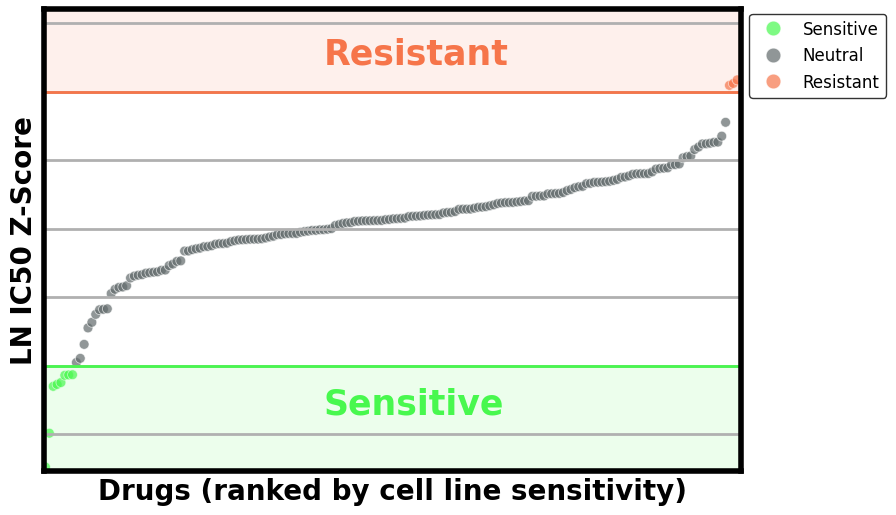

In [30]:
# 设置全局字体
plt.rcParams['font.sans-serif'] = ['Bahnschrift']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')
palette = {
    'Sensitive':'#48F84E',
    'Neutral':'#616A6B',
    'Resistant':'#F6754A'

}
# 以Z score为y轴，drug为x轴，Type为颜色，绘制散点图
plt.figure(figsize=(9,6))
# Y轴设置网格
plt.grid(axis='y',alpha=1,linestyle='-',linewidth=2)
sns.scatterplot(x='drug',y='Z score',hue='Type',data=df_single_cell,s=50,alpha=0.7,palette=palette)
plt.ylabel('LN IC50 Z-Score',fontsize=20,fontweight='bold')
plt.xlabel('Drugs (ranked by cell line sensitivity)',fontsize=20,fontweight='bold')
# 将legend放在画布外
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9),fontsize=12,markerscale=1.5,edgecolor='black')
plt.xticks([])
plt.yticks(fontsize=20)
plt.axhline(2, color='#F6754A', linewidth=2, linestyle='-')
plt.axhline(-2, color='#48F84E', linewidth=2, linestyle='-')
# 将Y小于-2整个画布涂色
plt.fill_between([0,df_single_cell.shape[0]], -2, -3.5, color='#48F84E', alpha=0.1)
# 在Y小于-2的区域写字：Sensitive
plt.text(72,-2.7,'Sensitive',fontsize=25,color='#48F84E',fontweight='bold')
# 将大于2整个画布涂色
plt.fill_between([0,df_single_cell.shape[0]], 2, 3.5, color='#F6754A', alpha=0.1)
# 在Y大于2的区域写字：Resistant
plt.text(72,2.4,'Resistant',fontsize=25,color='#F6754A',fontweight='bold')
# 去除上和右边框
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# 刻度加粗
plt.gca().tick_params(labelbottom=False, labelleft=False,length=0)
plt.xlim(left=-0.5,right=df_single_cell.shape[0])
plt.ylim(bottom=-3.54,top=3.2)
# 加粗横纵坐标
plt.gca().spines['bottom'].set_linewidth(4)
plt.gca().spines['left'].set_linewidth(4)
plt.gca().spines['right'].set_linewidth(4)
plt.gca().spines['top'].set_linewidth(4)

# plt.savefig('敏感与拮抗药物_IC50-ZScore散点图(CellBlind).png',dpi=300,bbox_inches='tight')
plt.show()

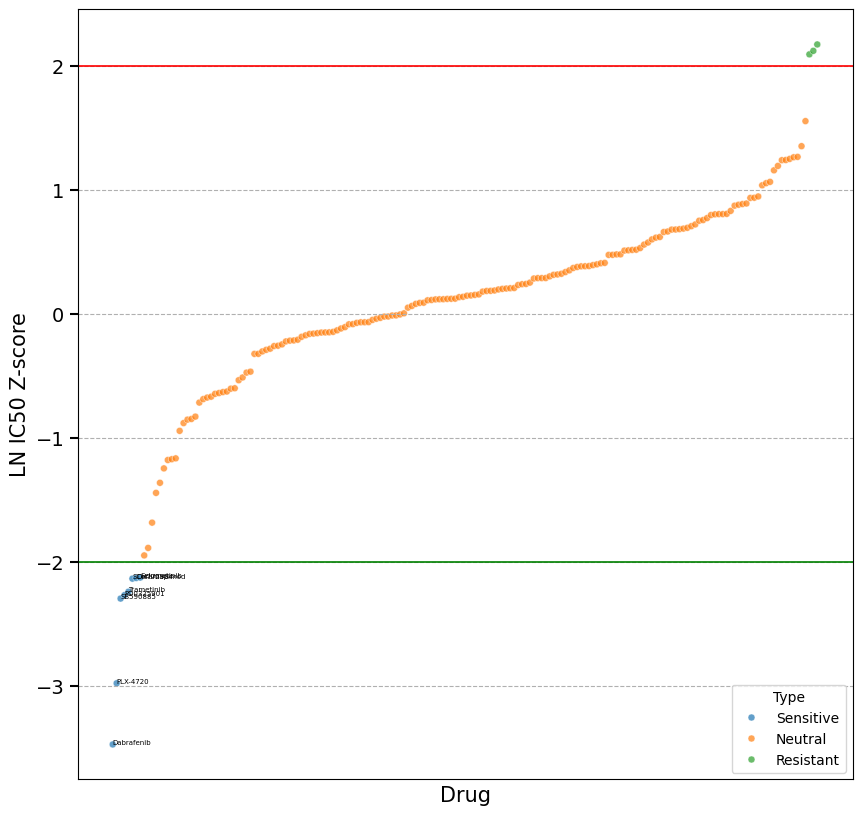

In [48]:
# 设置全局字体
plt.rcParams['font.sans-serif'] = ['Bahnschrift']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('default')
# 以Z score为y轴，drug为x轴，Type为颜色，绘制散点图
plt.figure(figsize=(10,10))
sns.scatterplot(x='drug',y='Z score',hue='Type',data=df_single_cell,s=25,alpha=0.7)
# Y轴设置网格
plt.grid(axis='y', linestyle='--')
plt.ylabel('LN IC50 Z-score',fontsize=15)
plt.xlabel('Drug',fontsize=15)
plt.xticks([])
plt.yticks(fontsize=14)
plt.axhline(2, color='red', linewidth=1.2, linestyle='-')
plt.axhline(-2, color='green', linewidth=1.2, linestyle='-')
# 将Y小于-2的点标记为敏感药物
for i in range(df_single_cell.shape[0]):
    if df_single_cell.iloc[i]['Z score']<=-2:
        plt.text(i,df_single_cell.iloc[i]['Z score'],df_single_cell.iloc[i]['drug'],fontsize=5)
# 去除上和右边框
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)
# 加粗横纵坐标
# plt.gca().spines['bottom'].set_linewidth(2)
# plt.gca().spines['left'].set_linewidth(2)
# 刻度加粗
plt.gca().tick_params(width=1.5, length=6)
plt.show()
